In [1]:
from geometry import Geometry3D
from sites import Site
import numpy as np
%matplotlib widget

In [2]:
from EQsystem import System

/opt/anaconda3/lib/python3.11/site-packages/kwant/solvers/default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


In [4]:
np.concatenate((np.arange(-1, 0, 0.1),np.arange(0,1,0.1)))

array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,
        0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9])

In [5]:
def density_function(r):
        spacing0 = 0.03  # spacing at r=0
        k = 1    # spacing increases by 0.05 per unit distance
        return spacing0 + k * r

    # Define a 3D simulation box: ((xmin, xmax), (ymin, ymax), (zmin, zmax))
    

In [6]:
testparams={"lattice_type": "square",   # or honeycomb_lattice, etc.
"box_size": ((-1.6, 1.6), (-3.1, 3.1), (-0.5, 0.5)),
"sampling_density_function": density_function,
"quantum_center": (0,0,0)     # optional, defaults to (0,0,0)
              }

In [7]:
syst=System(testparams,config_file="setup/setup_config1.json")

Generated 52811 points in 3D.
Voronoi cells have been created.
EQsystem is successfully initialized.


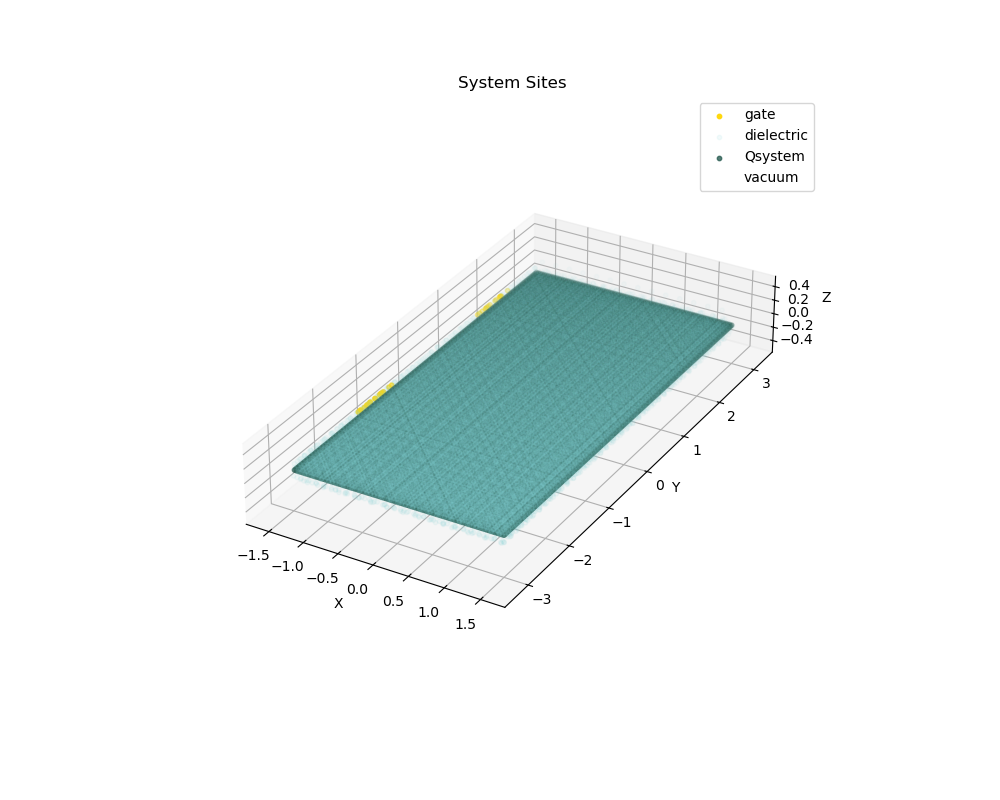

In [8]:
syst.plot_geometry()

In [8]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plotting


In [32]:
materials = list(syst.material_indices.keys())
colors_list = [tuple(c) for c in cm.rainbow(np.linspace(0, 1, len(materials)))]
color_map = dict(zip(materials, colors_list))

In [15]:
syst.sites[2].coordinates

array([-1.6, -2.2, -0.5])

In [19]:
color_map['Qsystem']

array([1.        , 0.70054304, 0.37841105, 1.        ])

In [39]:
syst.material_indices['dielectric']

[1203,
 1204,
 1205,
 1206,
 1207,
 1208,
 1209,
 1210,
 1211,
 1212,
 1213,
 1214,
 1215,
 1216,
 1217,
 1218,
 1219,
 1220,
 1221,
 1222,
 1223,
 1224,
 1225,
 1226,
 1227,
 1228,
 1229,
 1230,
 1231,
 1233,
 1234,
 1235,
 1236,
 1237,
 1238,
 1239,
 1240,
 1241,
 1242,
 1243,
 1244,
 1245,
 1246,
 1247,
 1248,
 1249,
 1250,
 1251,
 1252,
 1253,
 1254,
 1255,
 1256,
 1257,
 1258,
 1259,
 1260,
 1261,
 1263,
 1264,
 1265,
 1266,
 1267,
 1268,
 1269,
 1270,
 1271,
 1272,
 1273,
 1274,
 1275,
 1276,
 1277,
 1278,
 1279,
 1280,
 1281,
 1282,
 1283,
 1284,
 1285,
 1286,
 1287,
 1288,
 1289,
 1290,
 1291,
 1293,
 1294,
 1295,
 1296,
 1297,
 1298,
 1299,
 1300,
 1301,
 1302,
 1303,
 1304,
 1305,
 1306,
 1307,
 1308,
 1309,
 1310,
 1311,
 1312,
 1313,
 1314,
 1315,
 1316,
 1317,
 1318,
 1319,
 1320,
 1321,
 1323,
 1324,
 1325,
 1326,
 1327,
 1328,
 1329,
 1330,
 1331,
 1332,
 1333,
 1334,
 1335,
 1336,
 1337,
 1338,
 1339,
 1340,
 1341,
 1342,
 1343,
 1344,
 1345,
 1346,
 1347,
 1348,
 1349,

In [38]:
coords=np.array([syst.sites[idx].coordinates for idx in syst.material_indices['dielectric']])

In [45]:
list(syst.material_indices.keys())

['gate', 'dopants', 'dielectric', 'Qsystem', 'vacuum']

In [59]:
color_map['gate']

(0.5, 0.0, 1.0, 1.0)

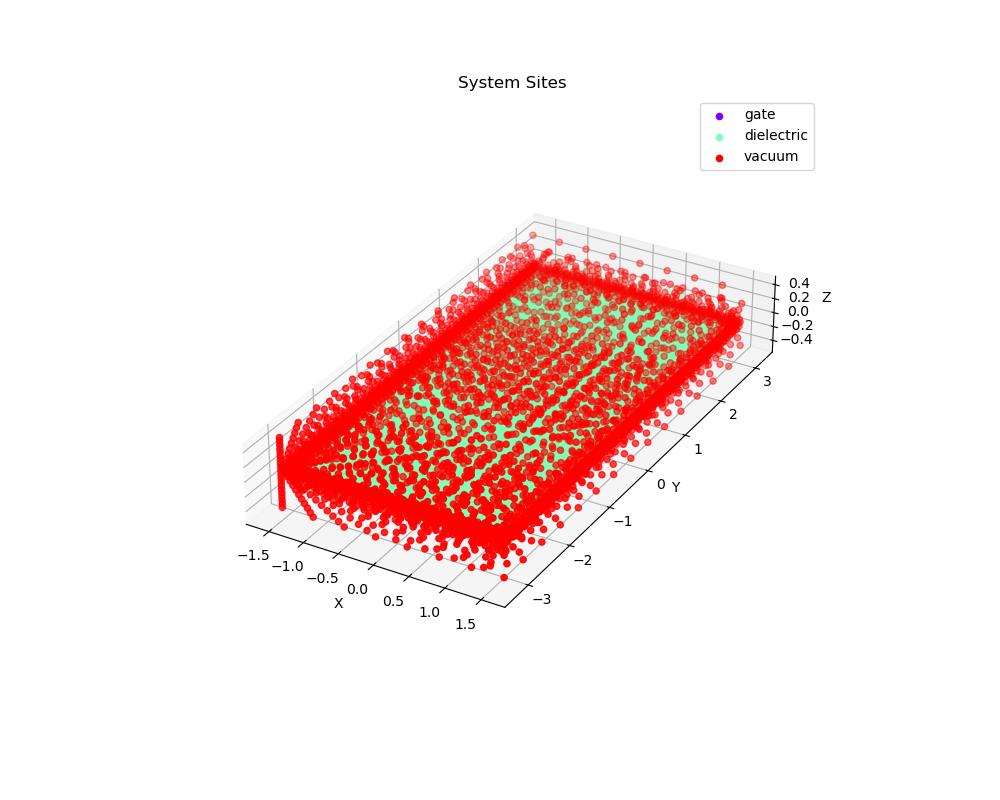

In [58]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


for mat in list(syst.material_indices.keys()):
        coords = np.array([syst.sites[idx].coordinates for idx in syst.material_indices[mat]])
        if len(coords)>0:
                ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2],
                        color=color_map[mat], label=mat, s=20)
ax.set_box_aspect((3.2, 6.2, 1))
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("System Sites")
ax.legend()
plt.show()

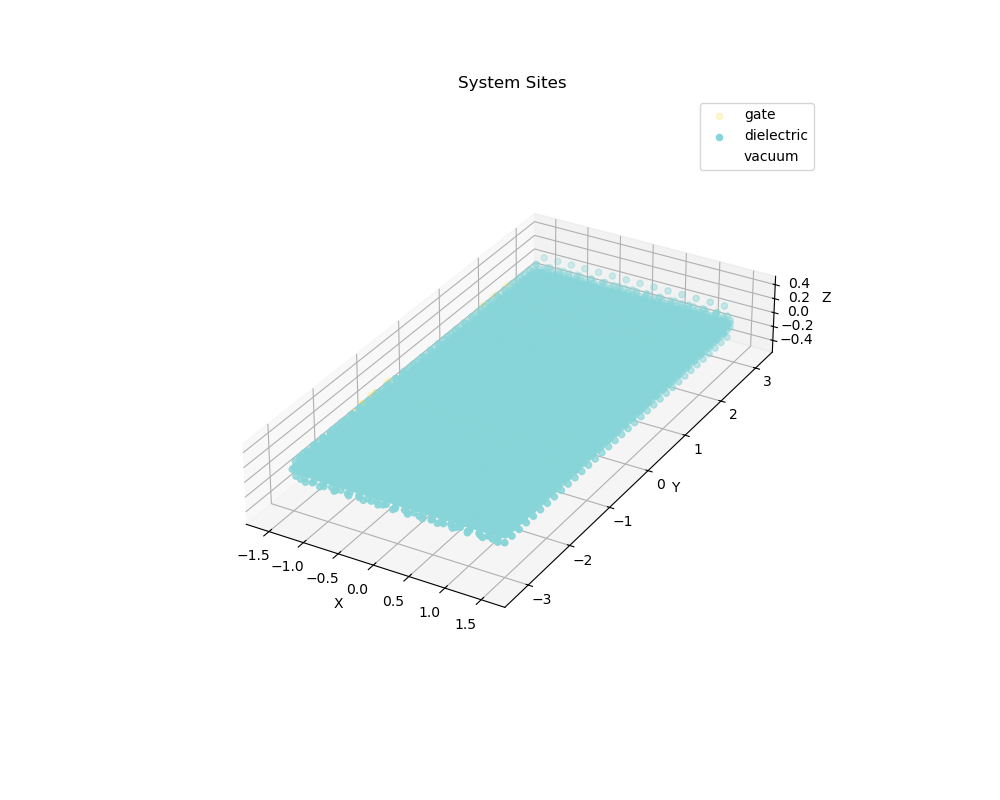

In [6]:
syst.plot_geometry()

In [3]:
def density_function(r):
        spacing0 = 0.05  # spacing at r=0
        k = 0.8    # spacing increases by 0.05 per unit distance
        return spacing0 + k * r

    # Define a 3D simulation box: ((xmin, xmax), (ymin, ymax), (zmin, zmax))
    

Generated 107 points in 3D.


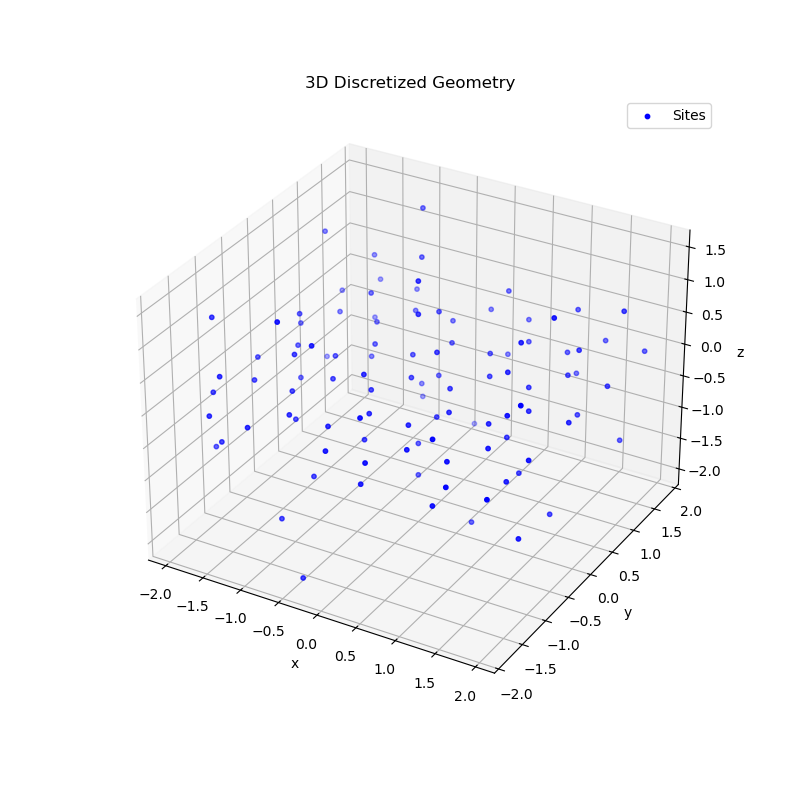

In [22]:
box_3d = ((-2.0, 2.0), (-2.0, 2.0), (-2.0, 2.0))
    
# Create a Geometry3D instance using the square_lattice function.
geom3d = Geometry3D(lattice_type="honeycomb", box_size=box_3d,
                    sampling_density_function=density_function, quantum_center=(0.0, 0.0, 0.0))

# Generate discretized points.
points_3d = geom3d.discretize()
print("Generated", len(points_3d), "points in 3D.")

# Compute the Voronoi tessellation (if needed).
geom3d.compute_voronoi()

# Plot the generated 3D points.#
geom3d.plot_geometry()

In [13]:
stest=np.random.rand(10,2)

In [14]:
stest

array([[0.39684064, 0.33881381],
       [0.50856838, 0.37697319],
       [0.6315333 , 0.21164243],
       [0.49293978, 0.94967188],
       [0.85141639, 0.51656476],
       [0.33002216, 0.64846158],
       [0.9679327 , 0.30422155],
       [0.01891675, 0.34737566],
       [0.06649236, 0.19061665],
       [0.29067235, 0.16425185]])

In [15]:
stest-(1,0)

array([[-0.60315936,  0.33881381],
       [-0.49143162,  0.37697319],
       [-0.3684667 ,  0.21164243],
       [-0.50706022,  0.94967188],
       [-0.14858361,  0.51656476],
       [-0.66997784,  0.64846158],
       [-0.0320673 ,  0.30422155],
       [-0.98108325,  0.34737566],
       [-0.93350764,  0.19061665],
       [-0.70932765,  0.16425185]])

In [43]:
import os
os.getcwd()

'/Users/yzaho/Library/Mobile Documents/com~apple~CloudDocs/PhD/EQuantum/EQuantum'

In [11]:
np.mean(stest[:,0])

0.7405668223934568

In [45]:
os.getcwd()

'/Users/yzaho/Library/Mobile Documents/com~apple~CloudDocs/PhD/EQuantum/EQuantum'

In [46]:
import json

with open("setup/setup_config1.json", "r") as f:
    config_data = json.load(f)

In [48]:
config_data.get("regions",[])

[{'name': 'dielectric',
  'bbox': {'xmin': -1.5,
   'xmax': 1.5,
   'ymin': -3.0,
   'ymax': 3.0,
   'zmin': -0.20000000298023224,
   'zmax': 0.0},
  'charge': 0.0,
  'potential': 0.0,
  'dielectric_constant': 1.0,
  'BCtype': 'n'},
 {'name': 'dielectric',
  'bbox': {'xmin': -1.5,
   'xmax': 1.5,
   'ymin': -3.0,
   'ymax': 3.0,
   'zmin': 0.0,
   'zmax': 0.20000000298023224},
  'charge': 0.0,
  'potential': 0.0,
  'dielectric_constant': 1.0,
  'BCtype': 'n'},
 {'name': 'gate',
  'bbox': {'xmin': -1.5,
   'xmax': 1.5,
   'ymin': 1.100000023841858,
   'ymax': 1.899999976158142,
   'zmin': 0.20000001788139343,
   'zmax': 0.4000000059604645},
  'charge': 0.0,
  'potential': 0.30000001192092896,
  'dielectric_constant': 1.0,
  'BCtype': 'd'},
 {'name': 'gate',
  'bbox': {'xmin': -1.5,
   'xmax': 1.5,
   'ymin': -1.899999976158142,
   'ymax': -1.100000023841858,
   'zmin': 0.20000001788139343,
   'zmax': 0.4000000059604645},
  'charge': 0.0,
  'potential': 0.30000001192092896,
  'dielectric

In [18]:
geom3d.plot_geometry()

<IPython.core.display.Javascript object>

In [19]:
import pyvista as pv
import numpy as np

def plot_voronoi_3d(vor):
    plotter = pv.Plotter()
    # The 3D Voronoi object contains regions that might not be closed.
    # Here we attempt to create surfaces from the finite regions.
    for region in vor.regions:
        if not region or -1 in region:
            continue
        # Create a PolyData object from the region vertices.
        region_points = vor.vertices[region]
        try:
            # Use Delaunay triangulation to form a surface.
            poly = pv.PolyData(region_points)
            surface = poly.delaunay_3d(alpha=1.0)
            if surface.n_cells > 0:
                plotter.add_mesh(surface, opacity=0.5, show_edges=True)
        except Exception as e:
            print("Failed to create a surface for a region:", e)
    
    # Add the original points for reference.
    plotter.add_points(vor.points, color="red", point_size=10)
    plotter.show()

# Example usage:
# vor = geometry3d.compute_voronoi()  # assuming geometry3d is an instance of your Geometry3D class.
# plot_voronoi_3d(vor)

In [ ]:
vor = geom3d.compute_voronoi()  # assuming geometry3d is an instance of your Geometry3D class.
plot_voronoi_3d(vor)

In [8]:
import pyvista as pv
pv.set_jupyter_backend('trame')

In [16]:
def polygon_area(vertices):
    """
    Compute the area of a planar convex polygon in 3D.
    
    This function triangulates the polygon using the first vertex as a reference.
    
    Parameters:
    - vertices: np.ndarray of shape (N,3) representing the polygon vertices in order.
    
    Returns:
    - area: float, the computed area of the polygon.
    """
    if len(vertices) < 3:
        return 0.0
    v0 = vertices[0]
    area = 0.0
    for i in range(1, len(vertices) - 1):
        v1 = vertices[i]
        v2 = vertices[i + 1]
        triangle_area = 0.5 * np.linalg.norm(np.cross(v1 - v0, v2 - v0))
        area += triangle_area
    return area

In [17]:

def create_sites_from_geometry_3d(geometry3d):
    """
    Create Site objects from a Geometry3D instance.
    
    This function assumes that geometry3d.points is an array of shape (N, 3) and that
    geometry3d.compute_voronoi() has been called to obtain a 3D Voronoi tessellation.
    It then builds a dictionary of Site objects and populates neighbor relationships
    based on the Voronoi ridges.
    
    Parameters:
    - geometry3d: an instance of your Geometry3D class.
    
    Returns:
    - sites: dict mapping site IDs to Site objects.
    """
    # Get the points and the 3D Voronoi object.
    points = geometry3d.points  # shape (N, 3)
    vor = geometry3d.compute_voronoi()
    
    sites = {}
    num_points = len(points)
    for i in range(num_points):
        # Initialize each site with default values (modify as needed).
        sites[i] = Site(site_id=i, coordinates=points[i], charge=0.0, potential=0.0, dielectric_constant=1.0)
    
    # Use vor.ridge_points and vor.ridge_vertices to assign neighbor relationships.
    # Each ridge corresponds to a common face between two Voronoi cells.
    for ridge, ridge_vertices in zip(vor.ridge_points, vor.ridge_vertices):
        i, j = ridge
        # Skip infinite ridges (if any vertex is -1, it means the ridge is unbounded).
        if -1 in ridge_vertices:
            continue
        # Extract the vertices of the common face.
        face_vertices = vor.vertices[ridge_vertices]
        # Compute the area of the face.
        face_area = polygon_area(face_vertices)
        # Compute the distance between the two sites.
        distance = np.linalg.norm(sites[i].coordinates - sites[j].coordinates)
        # Add neighbor relationship for both sites.
        sites[i].add_neighbor(j, face_area)
        sites[j].add_neighbor(i, face_area)
    
    return sites

In [35]:
list(sites_dict.values())[1].neighbors

{5: 1.1805726928466331,
 10: 0.23232292003798374,
 4: 12.123026442523273,
 21: 38.32674936246214,
 28: 5.210133426222529,
 27: 2.482664655616283}

In [42]:
from pymumps import DMumpsContext

ModuleNotFoundError: No module named 'pymumps'